In [1]:
import numpy as np
import torch

from scipy.stats import gumbel_r, weibull_min

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

num_points = 512
num_samples = 1024
num_weights = 256
nadir = torch.zeros(1, 2, **tkwargs)
shapes = [0.75, 1.0, 1.5, 2.0]
rate = torch.tensor([1.0, 2.0], **tkwargs)

# Get samples.
dists = {}
samples = {}
for shape in shapes:
    dists[shape] = weibull_min(shape, scale=1 / rate)
    samples[shape] = torch.tensor(
        dists[shape].rvs(size=(num_points, num_samples, 2)), **tkwargs
    )

# Get fronts.
u = torch.linspace(0, 1, num_weights, **tkwargs).unsqueeze(-1)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(u)
scalarization_fn = LengthScalarization(weights=weights, ref_points=nadir)

qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

N = [4, 16, 64, 256]
mean_lengths = {}
mean_fronts = {}
quantile_lengths = {}
quantile_fronts = {}

for shape in shapes:
    mean_lengths[shape] = {}
    mean_fronts[shape] = {}
    quantile_lengths[shape] = {}
    quantile_fronts[shape] = {}
    for n in N:
        quantile_lengths[shape][n] = {}
        quantile_fronts[shape][n] = {}


for shape in shapes:
    for n in N:
        lengths = scalarization_fn(samples[shape][:n, ...]).max(dim=0).values

        mean_length = lengths.mean(dim=-2)
        mean_lengths[shape][n] = mean_length
        mean_fronts[shape][n] = nadir + mean_length.unsqueeze(-1) * weights

        for q in qs:
            q_lengths = lengths.quantile(q=q, dim=-2)
            quantile_lengths[shape][n][q] = q_lengths

            q_front = nadir + q_lengths.unsqueeze(-1) * weights
            quantile_fronts[shape][n][q] = q_front

In [3]:
# Get theoretical fronts.
gumbel_mean_lengths = {}
gumbel_mean_fronts = {}

gumbel_quantile_lengths = {}
gumbel_quantile_fronts = {}

gumbel_rv = gumbel_r()

for shape in shapes:
    gumbel_mean_lengths[shape] = {}
    gumbel_mean_fronts[shape] = {}
    gumbel_quantile_lengths[shape] = {}
    gumbel_quantile_fronts[shape] = {}
    for n in N:
        gumbel_quantile_lengths[shape][n] = {}
        gumbel_quantile_fronts[shape][n] = {}

one = torch.ones(1, **tkwargs)
for shape in shapes:
    k = torch.sum((rate * weights) ** shape, dim=-1) ** (1 / shape)
    for n in N:
        a_n = torch.log(n * one) ** (1 / shape - 1) / (shape * k)
        b_n = torch.log(n * one) ** (1 / shape) / k

        mean_length = gumbel_rv.moment(1)
        gumbel_mean_lengths[shape][n] = mean_length
        gumbel_mean_fronts[shape][n] = (
            nadir + (a_n * mean_length + b_n).unsqueeze(-1) * weights
        )

        for q in qs:
            q_lengths = torch.tensor(gumbel_rv.ppf(q=q), **tkwargs)
            gumbel_quantile_lengths[shape][n][q] = q_lengths

            q_front = nadir + (a_n * q_lengths + b_n).unsqueeze(-1) * weights
            gumbel_quantile_fronts[shape][n][q] = q_front

In [4]:
# Get the bounds.
bounds = {}

for shape in shapes:
    bounds[shape] = {}
    for n in N:
        last_quantile = quantile_fronts[shape][n][qs[-1]]
        max_values = torch.max(last_quantile, dim=0).values
        bounds[shape][n] = torch.row_stack(
            [nadir - 0.05, torch.round(max_values, decimals=1) + 0.3]
        )

In [5]:
quantile_colors = pl.cm.viridis(torch.linspace(0, 1, len(qs)))

# Get the contours.
grid_length = 64

X1s = {}
X2s = {}
pdfs = {}

for shape in shapes:
    X1s[shape] = {}
    X2s[shape] = {}
    pdfs[shape] = {}

for shape in shapes:
    for n in N:
        bound = bounds[shape][n]
        shift = 0.05 * (bound[1, :] - bound[0, :])
        t1 = torch.linspace(bound[0, 0] - shift[0], bound[1, 0], grid_length, **tkwargs)
        t2 = torch.linspace(bound[0, 1] - shift[1], bound[1, 1], grid_length, **tkwargs)

        X1, X2 = torch.meshgrid(t1, t2, indexing="xy")
        all_X = torch.column_stack(
            [
                X1.reshape(grid_length**2),
                X2.reshape(grid_length**2),
            ]
        )

        pdf = dists[shape].pdf(all_X).prod(axis=-1).reshape(grid_length, grid_length)
        X1s[shape][n] = X1
        X2s[shape][n] = X2
        pdfs[shape][n] = pdf

In [6]:
def plot_gumbel(shape, n):
    plt.contour(
        X1s[shape][n],
        X2s[shape][n],
        pdfs[shape][n],
        cmap="jet",
        alpha=0.2,
        zorder=1,
    )

    # Theoretical fronts.
    gumbel_mean_front = gumbel_mean_fronts[shape][n]
    plt.plot(
        gumbel_mean_front[:, 0],
        gumbel_mean_front[:, 1],
        color="crimson",
        linewidth=5,
        alpha=0.5,
        zorder=5,
    )
    for i, q in enumerate(qs):
        gumbel_quantile_front = gumbel_quantile_fronts[shape][n][q]
        plt.plot(
            gumbel_quantile_front[:, 0],
            gumbel_quantile_front[:, 1],
            alpha=0.2,
            color=quantile_colors[i],
            linewidth=5,
            zorder=5,
        )

    # Sample fronts.
    mean_front = mean_fronts[shape][n]
    plt.plot(
        mean_front[:, 0],
        mean_front[:, 1],
        color="crimson",
        linewidth=3,
        alpha=1,
        linestyle=":",
        zorder=5,
    )

    for i, q in enumerate(qs):
        quantile_front = quantile_fronts[shape][n][q]
        plt.plot(
            quantile_front[:, 0],
            quantile_front[:, 1],
            alpha=1,
            color=quantile_colors[i],
            linewidth=3,
            linestyle=":",
            zorder=5,
        )
    plt.scatter(
        nadir[:, 0],
        nadir[:, 1],
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )
    plt.title(
        rf"$\alpha$=${shape}$, $\boldsymbol{{\beta}}$=$(1,2)$, $N$=${n}$",
        fontsize=20,
    )

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    return

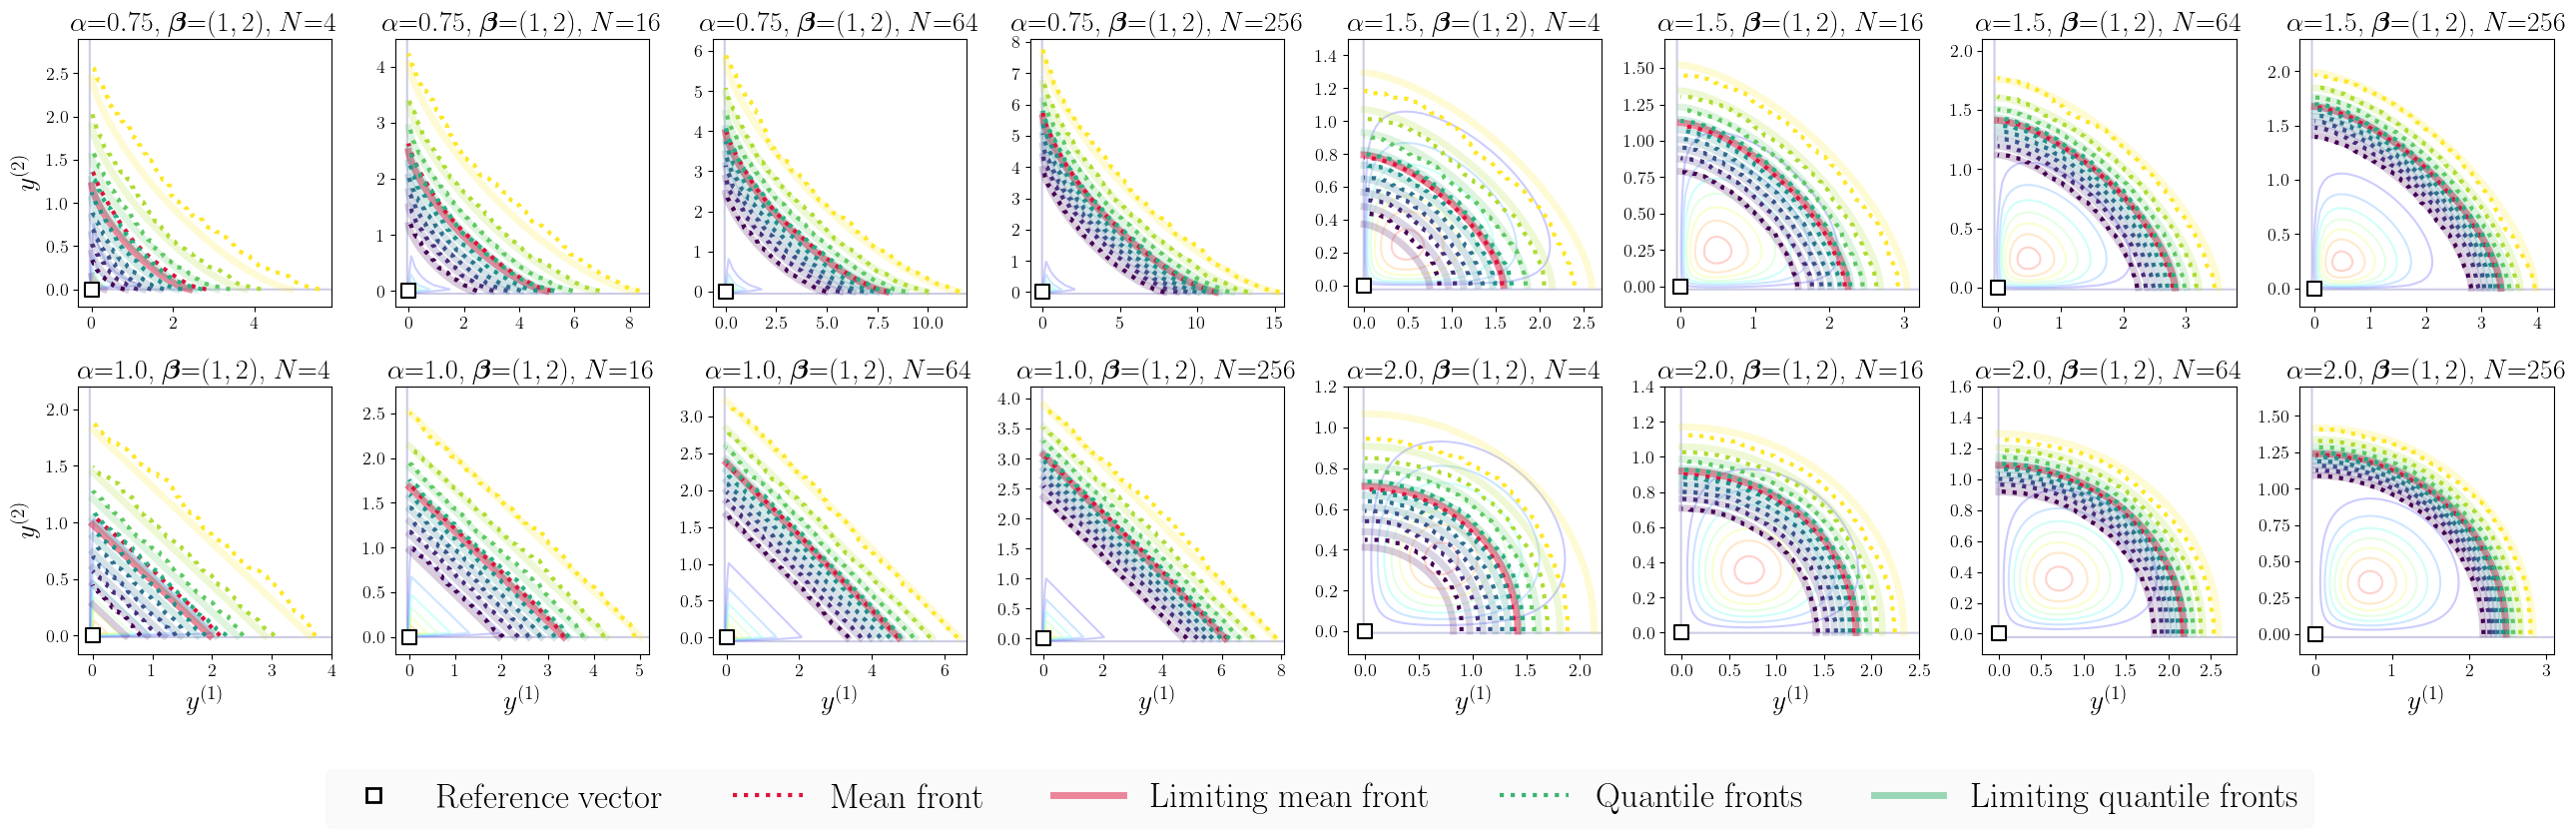

In [7]:
num_rows = 2
num_cols = 8

fig, axes = plt.subplots(num_rows, num_cols, figsize=(32, 8))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.3
)

# Shape 0.
for col, n in enumerate(N):
    index = col
    plt.subplot(num_rows, num_cols, index + 1)
    plot_gumbel(shapes[0], n)

    if col == 0:
        plt.ylabel(r"$y^{(2)}$", fontsize=20)

# Shape 1.
for col, n in enumerate(N):
    index = col + 8
    plt.subplot(num_rows, num_cols, index + 1)
    plot_gumbel(shapes[1], n)

    if col == 0:
        plt.ylabel(r"$y^{(2)}$", fontsize=20)
    plt.xlabel(r"$y^{(1)}$", fontsize=20)

# Shape 2.
for col, n in enumerate(N):
    index = col + 4
    plt.subplot(num_rows, num_cols, index + 1)
    plot_gumbel(shapes[2], n)


# Shape 3.
for col, n in enumerate(N):
    index = col + 12
    plt.subplot(num_rows, num_cols, index + 1)
    plot_gumbel(shapes[3], n)
    plt.xlabel(r"$y^{(1)}$", fontsize=20)


#########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    linewidth=5,
    alpha=0.5,
    label=r"Limiting mean front",
)

red_dotted_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle=":",
    linewidth=3,
    alpha=1,
    label=r"Mean front",
)

green_line = mlines.Line2D(
    [],
    [],
    color="mediumseagreen",
    linestyle="-",
    linewidth=5,
    alpha=0.5,
    label=r"Limiting quantile fronts",
)

green_dotted_line = mlines.Line2D(
    [],
    [],
    color="mediumseagreen",
    linestyle=":",
    linewidth=3,
    alpha=1,
    label=r"Quantile fronts",
)


axes[num_rows - 1, 0].legend(
    handles=[
        (white_square),
        (red_dotted_line),
        (red_line),
        (green_dotted_line),
        (green_line),
    ],
    ncol=5,
    fontsize=25,
    loc=(0.975, -0.65),
    facecolor="k",
    framealpha=0.02,
)

plt.show()